# Working with Text Data and Uncertainty

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Load sample text data using sklearn.


In [ ]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train',categories=['alt.atheism','soc.religion.christian','comp.graphics'],shuffle=True, random_state=42)
twenty_test = fetch_20newsgroups(subset='test',categories=['alt.atheism','soc.religion.christian','comp.graphics'],shuffle=True, random_state=42)

# This is out of distribution data. Not seen in training.
twenty_ood = fetch_20newsgroups(subset='test',categories=['sci.med','sci.space','rec.autos'],shuffle=True, random_state=42)

Print an example data point.

In [ ]:
print(twenty_train.data[0])

From: chrisb@tafe.sa.edu.au (Chris BELL)
Subject: Re: Don't more innocents die without the death penalty?
Organization: South Australian Regional Academic and Research Network
Lines: 19
Distribution: world
NNTP-Posting-Host: baarnie.tafe.sa.edu.au

"James F. Tims" <p00168@psilink.com> writes:

>By maintaining classes D and E, even in prison, it seems as if we 
>place more innocent people at a higher risk of an unjust death than 
>we would if the state executed classes D and E with an occasional error.

I would rather be at a higher risk of being killed than actually killed by
                              ^^^^                      ^^^^^^^^
mistake.  Though I do agree with the concept that the type D and E murderers
are a massive waste of space and resources I don't agree with the concept:

	killing is wrong
	if you kill we will punish you
	our punishment will be to kill you.

Seems to be lacking in consistency.

--
"I know" is nothing more than "I believe" with pretentions.



Turn the text data into a set of numerical vectors, using count vectorization.
And use TFIDF to standardize the counts between documents.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

count_vect = CountVectorizer(stop_words='english')
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_test_counts = count_vect.transform(twenty_test.data)
X_ood_counts = count_vect.transform(twenty_ood.data)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_ood_tfidf = tfidf_transformer.transform(X_ood_counts)

Next, train multiple neural network models. The multiple models will allow us to quanify uncertainty in our predictions.

In [ ]:
from sklearn.neural_network import MLPClassifier

models = [MLPClassifier(hidden_layer_sizes=(50,50)),
          MLPClassifier(hidden_layer_sizes=(50,50)),
          MLPClassifier(hidden_layer_sizes=(50,50)),
          MLPClassifier(hidden_layer_sizes=(50,50)),
          MLPClassifier(hidden_layer_sizes=(50,50))]

for model in models:
  model.fit(X_train_tfidf, twenty_train.target)

Now, sample softmax outputs for each of the models. We will track in distribution and out of distribution test data separately

In [ ]:
# Predict on test and out of distribution data.
preds_test = []
preds_ood = []
for model in models:
  preds_test.append(model.predict_proba(X_test_tfidf))
  preds_ood.append(model.predict_proba(X_ood_tfidf))

# The shape is (num models, num data points, num classes).
preds_test = np.array(preds_test)
preds_ood = np.array(preds_ood)

Next, evaluate the model ensemble on the test data.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(twenty_test.target,np.argmax(np.mean(preds_test,axis=0),axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       319
           1       0.97      0.98      0.97       389
           2       0.91      0.98      0.94       398

    accuracy                           0.95      1106
   macro avg       0.95      0.95      0.95      1106
weighted avg       0.95      0.95      0.95      1106



Next measure the uncertainty using the mean (across classes) softmax variance (across models). We can then compare uncertainty for in and out of distribution data

In [ ]:
indist_uncertainty = np.mean(np.var(preds_test,axis=0),axis=1)
ood_uncertainty = np.mean(np.var(preds_ood,axis=0),axis=1)

Show that out of distribution data tend to have higher uncertainty.

Text(0.5, 1.0, 'Uncertainty')

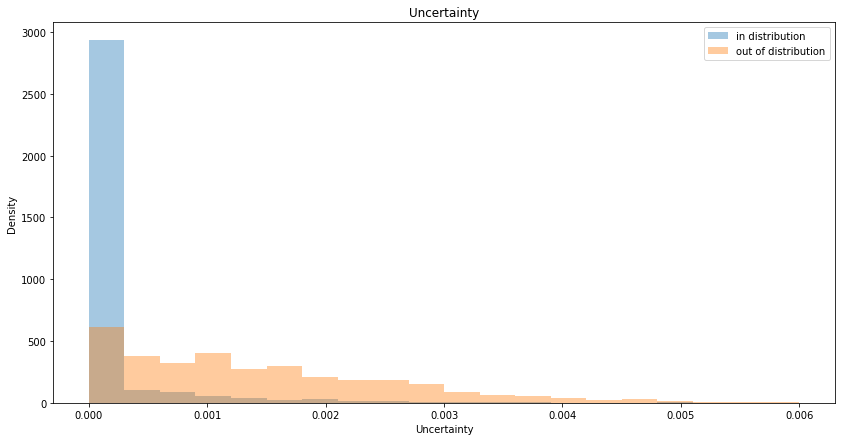

In [ ]:
plt.figure(figsize=(14,7))
plt.hist(indist_uncertainty, label='in distribution',alpha=0.4, density=True, bins=20, range=(0,0.006))
plt.hist(ood_uncertainty, label='out of distribution',alpha=0.4, density=True, bins=20, range=(0,0.006))
plt.legend()
plt.xlabel('Uncertainty')
plt.ylabel('Density')
plt.title('Uncertainty')

Finally, show that wrong predictions tend to have higher uncertainty.


Text(0.5, 1.0, 'Uncertainty')

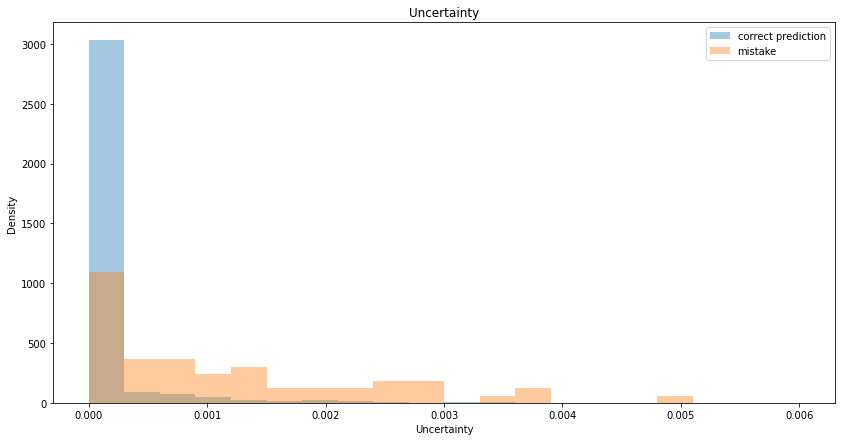

In [ ]:
is_correct = twenty_test.target==np.argmax(np.mean(preds_test,axis=0),axis=1)

# We can compare uncertainty for test data points the model got wrong and correct.
correct_uncertainty = np.mean(np.var(preds_test[:,is_correct,:],axis=0),axis=1)
mistake_uncertainty = np.mean(np.var(preds_test[:,~is_correct,:],axis=0),axis=1)

# Wrong predictions tend to have higher uncertainty.
plt.figure(figsize=(14,7))
plt.hist(correct_uncertainty, label='correct prediction',alpha=0.4, density=True, bins=20, range=(0,0.006))
plt.hist(mistake_uncertainty, label='mistake',alpha=0.4, density=True, bins=20, range=(0,0.006))
plt.legend()
plt.xlabel('Uncertainty')
plt.ylabel('Density')
plt.title('Uncertainty')

### Conclude by explaining in words why uncertainty estimation is valuable.

It allows us to quantify and measure the uncertainty in our predictions and see the accuracy of a prediciton. And helps us eventually find the better predictions. It can narrow down where the uncertainty comes from and find where to change our methods to find the more accurate models. This is helpful because neural networks are unsure whether the predicitons are correct or not.



### Approximately how long did this homework take you to complete?

Less than an hour